This reproduction study prerequisites that you have obtained a copy of the [ETC Corpus of Non-Native and Written English](https://catalog.ldc.upenn.edu/LDC2014T06).
Proceed to download and set up dependencies by running `pip3 install -r requirements.txt`.
Then execute this notebook. If you want to use the `annotation` feature you need to download the annotations [from GitHub](https://github.com/Fohlen/toefl11-languagetool-annotations) and place them into the `responses/annotations` folder.

In [1]:
TOEFL11_SCRIPT_PATH = 'toefl11.py'
DATA_DIR = "/home/fohlen/Documents/Bachelor/Data/ETS_Corpus_of_Non-Native_Written_English_LDC2014T06/ETS_Corpus_of_Non-Native_Written_English/data/text"

import requests
import os
from nltk import download

# NLTK downloads
download('punkt')
download('averaged_perceptron_tagger')

# Download the onix stopwords corpus (http://www.lextek.com/manuals/onix/stopwords1.html)
onix_path = os.path.join(os.getcwd(), 'onix.txt')
if not os.path.exists(onix_path):
    print("Downloading to " + onix_path)
    url = 'https://raw.githubusercontent.com/igorbrigadir/stopwords/master/en/onix.txt'
    r = requests.get(url, allow_redirects=True)
    with open(onix_path, 'wb') as f:
        f.write(r.content)

[nltk_data] Downloading package punkt to /home/fohlen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fohlen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Load datasets and vectorize test and training data.

In [2]:
from KoppelVectorizer import KoppelVectorizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np

# The original experiment uses 129 essays for development where we use 5x the amount
development = load_dataset(TOEFL11_SCRIPT_PATH,
    data_dir=DATA_DIR,
    split='train[:5%]',
    name="annotated-plain-text"
)

vectorizer = KoppelVectorizer(features=['stopwords', 'trigrams', 'bigrams', 'rare_pos_tags', 'annotation'])
X_dev_train, X_dev_test, \
A_train, A_test, \
y_train, y_test = train_test_split(development["Text"], development["Annotation"], development["Language"], test_size=0.33, random_state=42)
labels = list(set(development["Language"]))
X_train = vectorizer.fit_transform(X_dev_train, A_train)
y_train = np.array([labels.index(language) for language in y_train])
X_test = vectorizer.transform(X_dev_test, A_test)
y_test = np.array([labels.index(language) for language in y_test])

Using custom data configuration annotated-plain-text-0d2e219b700317ed
Reusing dataset toef_l11 (/home/fohlen/.cache/huggingface/datasets/toef_l11/annotated-plain-text-0d2e219b700317ed/1.0.0/b9c961e4f11574a27d305d175682506a660414f7014938666c8b0848b288ed67)
Using custom data configuration default-39065f4257a44a0b
Reusing dataset text (/home/fohlen/.cache/huggingface/datasets/text/default-39065f4257a44a0b/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)
Using custom data configuration default-cedc0cd0a179dec0
Reusing dataset text (/home/fohlen/.cache/huggingface/datasets/text/default-cedc0cd0a179dec0/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


Train a multi-class linear SVM according to Koppel et al.
Optionally one could try retraining for different feature sets (see KoppelVectorizer).

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

tuned_parameters = [
    {'kernel': ['rbf', 'poly', 'linear'], 'C': [100, 1000]},
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/home/fohlen/Documents/Bachelor/koppel-reproduction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fohlen/Documents/Bachelor/koppel-reproduction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fohlen/Documents/Bachelor/koppel-reproduction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Best parameters set found on development set:

{'C': 1000, 'kernel': 'poly'}

Grid scores on development set:

0.261 (+/-0.093) for {'C': 100, 'kernel': 'rbf'}
0.241 (+/-0.144) for {'C': 100, 'kernel': 'poly'}
0.262 (+/-0.097) for {'C': 100, 'kernel': 'linear'}
0.261 (+/-0.093) for {'C': 1000, 'kernel': 'rbf'}
0.266 (+/-0.163) for {'C': 1000, 'kernel': 'poly'}
0.262 (+/-0.097) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        15
           1       0.50      0.35      0.41        20
           2       0.15      0.43      0.22         7
           3       0.23      0.43      0.30        14
           4       0.25      0.12      0.16        17
           5       0.33      0.38      0.36        21
           6       0.11      0.22      0.15         9
           7  

Check which features are contributing to the accuracy:

('stopwords',)
('trigrams',)
('bigrams',)
('rare_pos_tags',)
('annotation',)
('stopwords', 'trigrams')
('stopwords', 'bigrams')
('stopwords', 'rare_pos_tags')
('stopwords', 'annotation')
('trigrams', 'bigrams')
('trigrams', 'rare_pos_tags')
('trigrams', 'annotation')
('bigrams', 'rare_pos_tags')
('bigrams', 'annotation')
('rare_pos_tags', 'annotation')
('stopwords', 'trigrams', 'bigrams')
('stopwords', 'trigrams', 'rare_pos_tags')
('stopwords', 'trigrams', 'annotation')
('stopwords', 'bigrams', 'rare_pos_tags')
('stopwords', 'bigrams', 'annotation')
('stopwords', 'rare_pos_tags', 'annotation')
('trigrams', 'bigrams', 'rare_pos_tags')
('trigrams', 'bigrams', 'annotation')
('trigrams', 'rare_pos_tags', 'annotation')
('bigrams', 'rare_pos_tags', 'annotation')
('stopwords', 'trigrams', 'bigrams', 'rare_pos_tags')
('stopwords', 'trigrams', 'bigrams', 'annotation')
('stopwords', 'trigrams', 'rare_pos_tags', 'annotation')
('stopwords', 'bigrams', 'rare_pos_tags', 'annotation')
('trigrams', 'b

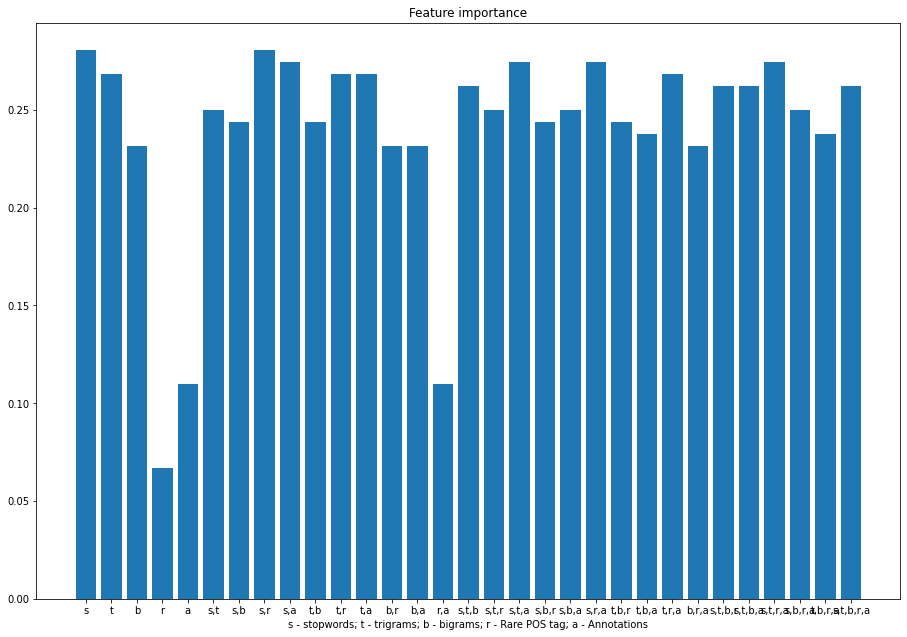

In [4]:
from itertools import chain, combinations
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))

features = ['stopwords', 'trigrams', 'bigrams', 'rare_pos_tags', 'annotation']
feature_combinations = list(powerset(features))[1:]
feature_scores = []

for combination in feature_combinations:
    print(combination)
    vectorizer.features = list(combination)
    X_train, X_test = vectorizer.transform(X_dev_train, A_train), vectorizer.transform(X_dev_test, A_test)
    clf = SVC(kernel='linear', C=100)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    feature_scores.append(accuracy_score(y_predict, y_test))

def combination_to_str(combination):
    return ",".join([s[0] for s in combination])

fig = plt.figure()
ax = fig.add_axes([0,0,2,2])

ax.bar([combination_to_str(combination) for combination in feature_combinations], feature_scores)
plt.title("Feature importance")
plt.xlabel("s - stopwords; t - trigrams; b - bigrams; r - Rare POS tag; a - Annotations")
plt.show()

Perform 10 fold cross-validation as described in Koppel et al.

In [ ]:
vals_ds = load_dataset(TOEFL11_SCRIPT_PATH,
    data_dir=DATA_DIR,
    split=[
        f'validation[{k}%:{k+10}%]' for k in range(0, 100, 10)
    ],
    name="plain-text"
)
trains_ds = load_dataset(TOEFL11_SCRIPT_PATH,
    data_dir=DATA_DIR,
    split=[
        f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)
    ],
    name="plain-text"
)

folding_scores = []
max_model = None
vectorizer.features = ['stopwords', 'trigrams', 'bigrams']

for val_ds, train_ds in zip(vals_ds, trains_ds):
    X_train, X_test = vectorizer.transform(train_ds["Text"]), vectorizer.transform(val_ds["Text"])
    y_train, y_test = np.array([labels.index(language) for language in train_ds["Language"]]), np.array([labels.index(language) for language in val_ds["Language"]])
    model = SVC(kernel='rbf', C=1000)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    score = accuracy_score(y_test, y_predict)
    if score > max(folding_scores, default=0):
        max_model = model
    print(score)
    folding_scores.append(score)

Using custom data configuration plain-text-0d2e219b700317ed
Reusing dataset toef_l11 (/home/fohlen/.cache/huggingface/datasets/toef_l11/plain-text-0d2e219b700317ed/1.0.0/b9c961e4f11574a27d305d175682506a660414f7014938666c8b0848b288ed67)
Using custom data configuration plain-text-0d2e219b700317ed
Reusing dataset toef_l11 (/home/fohlen/.cache/huggingface/datasets/toef_l11/plain-text-0d2e219b700317ed/1.0.0/b9c961e4f11574a27d305d175682506a660414f7014938666c8b0848b288ed67)


0.6363636363636364
0.4818181818181818
0.4636363636363636
0.509090909090909
0.509090909090909
0.5454545454545454
0.5272727272727272
0.5818181818181818
0.5363636363636364


Evaluate feature matrix for optimum model:

In [1]:
from statistics import mean
from sklearn.metrics import plot_confusion_matrix

print("Maximum model accuracy: %s mean model accuracy: %s" % (max(folding_scores), mean(folding_scores)))
print()
y_pred = max_model.predict(X_test)
print(classification_report(y_test, y_pred))
print()

plot_confusion_matrix(max_model, X_test, y_test, display_labels=labels)

NameError: name 'folding_scores' is not defined